# Introduction

Task : Multi-class Calssificaiton   
Method : k-Nearest Neighborhood   
Dataset : CIFAR-10

# 0. Set Environment

In [ ]:
import torch
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import time

# 1. Process Data

## 1-1. Download Data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, directory, train = None, transform = None, target_transform = None):
        self.train = train       
        self.directory = directory
        self.transform = transform
        self.target_transform = target_transform
        self.data = None
        self.labels = None
        
        self.fileloader()
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def fileloader(self):
        if self.train == True:
            filestart = 'data_batch'
        if self.train == False:
            filestart = 'test_batch'
            
        for filename in os.listdir(self.directory):
            if filename.startswith(filestart):
                filepath = os.path.join(self.directory, filename)
                file = self.unpickle(filepath)
                if self.data is None:
                    self.data = file[b'data']
                    self.labels = file[b'labels']
                else:
                    self.data = np.vstack((self.data, file[b'data']))
                    self.labels = np.concatenate((self.labels, file[b'labels']))
                    
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [18]:
directory = './data/cifar-10-batches-py/'

train_dataset = CustomDataset(directory, train = True)
test_dataset = CustomDataset(directory, train = False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [49000, 1000])

# 2. Define Model

## 2-1. Model Structure

In [34]:
class NearestNeighborClassifier():
    def __init__(self):
        pass
    
    def train(self, X, Y):
        self.Xtr = X
        self.Ytr = Y
        
    def predict(self, X, k = None):
        num_test = X.shape[0]
        Ypred = np.zeros(num_test, dtype = self.Ytr.dtype)
        
        for i in tqdm(range(num_test)):
            distances = np.sum(self.Xtr - X[i,:], axis = 1)
            
            distance_min_k_idx = np.argpartition(distances, k)[:k]
            predict_min_k = self.Ytr[distance_min_k_idx]
            unique_value, count = np.unique(predict_min_k, return_counts = True)
            most_common_prediction = unique_value[np.argmax(count)]
            
            Ypred[i] = most_common_prediction
            
        return Ypred
    
    def nearestimage(self, X):
        distances = np.sum(self.Xtr - X, axis=1)
        
        min_index = np.argmin(distances)
        Xpred = self.Xtr[min_index]
        
        reshaped_X = X.reshape((3, 32, 32))
        transposed_X = np.transpose(reshaped_X, (1, 2, 0))
        
        reshaped_Xpred = Xpred.reshape((3, 32, 32))
        transposed_Xpred = np.transpose(reshaped_Xpred, (1, 2, 0))
        
        concatenated_X = np.concatenate((transposed_X, transposed_Xpred), axis=1)
        
        return concatenated_X, self.Ytr[min_index]

# 3. Train

In [21]:
validation_accuracies = []
for k in [1,3,5,10,20,50,100]:
    print(f"k : {k}")
    nn = NearestNeighborClassifier()
    nn.train(train_set[:][0], train_set[:][1])
    Yval_predict = nn.predict(val_set[:][0], k = k)
    acc = np.mean(Yval_predict == val_set[:][1])
    print('accuracy : %f' % (acc))
    
    validation_accuracies.append((k, acc))

k : 1


100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]


accuracy : 0.264000
k : 3


100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]


accuracy : 0.235000
k : 5


100%|██████████| 1000/1000 [01:07<00:00, 14.74it/s]


accuracy : 0.241000
k : 10


100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]


accuracy : 0.226000
k : 20


100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s]


accuracy : 0.234000
k : 50


100%|██████████| 1000/1000 [01:08<00:00, 14.58it/s]


accuracy : 0.226000
k : 100


100%|██████████| 1000/1000 [01:07<00:00, 14.82it/s]

accuracy : 0.221000


# 4. Test

In [23]:
k = max(validation_accuracies, key = lambda x: x[1])[0]
print(f"k : {k}")

nn = NearestNeighborClassifier()
nn.train(train_set[:][0], train_set[:][1])
Yte_predict = nn.predict(test_dataset[:][0], k = k)
acc = np.mean(Yte_predict == test_dataset[:][1])
print('accuracy : %f' % (acc))

k : 1


100%|██████████| 10000/10000 [11:13<00:00, 14.86it/s]

accuracy : 0.247900


# 5. Inference

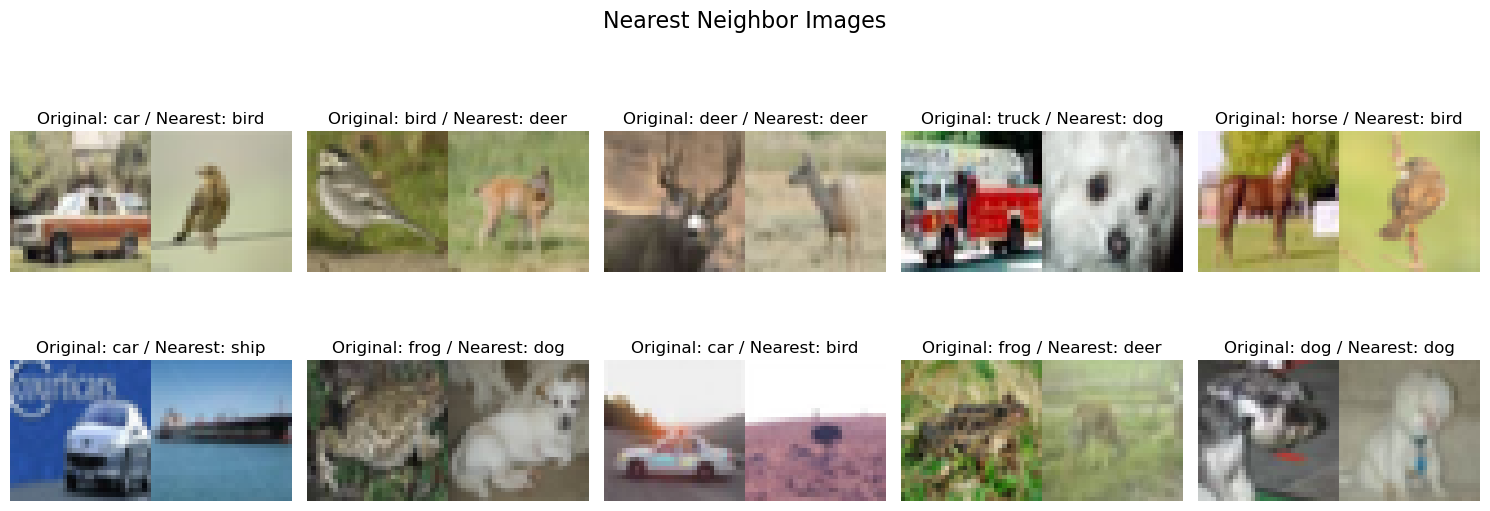

In [39]:
nn = NearestNeighborClassifier()
nn.train(train_set[:][0], train_set[:][1])

num_rows = 2
num_cols = 5
plt.figure(figsize=(15, 6))
plt.suptitle('Nearest Neighbor Images', fontsize=16)

for i in range(num_rows * num_cols):
    index = np.random.randint(0, 10000)
    X_test, label_test = test_dataset[index]
    nearest_img, nearest_class = nn.nearestimage(X_test)
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(nearest_img)
    plt.axis('off')
    plt.title(f'Original: {classes[label_test]} / Nearest: {classes[nearest_class]}')

plt.tight_layout() 
plt.show()